In [1]:
import pandas as pd
import pyx
import binascii
from scapy.all import *
import socket
import seaborn as sns
from IPython.display import IFrame
sns.set()
import pickle

In [2]:
def protocol_index_to_name(protocol_index):
    with open('./protocol.pkl', 'rb') as f:
        protocols = pickle.load(f)
    
    value =  protocols.get(str(protocol_index))
    
    if value != None:
        return value
    else:
        return str(protocol_index)


# PLUTO
## Plutot Logical UDP/TCP Organizer

### Note:
The scapy packets are build as nested python dictionaries (kinda). Each layer (Ethernet, IP, TCP/UDP, etc) can be accessed as PACKET[LAYER]


Unless a directional wifi receiver/transmitter is used, all signals expand in a sphere from the wifi adapter.

Anyone with a wifi adapter in the range of the sender can listen to these signals, and store them. 

If you don't have the password to the network, all data will be encrypted with the password however.

(TODO, sending interruptions and listening to handshakes and decoding encrypted wifi)

Also, if https is used an additonal key is used to encrypt the data. 

How to enhance security?

### Functionality
* Packets to dataframe
* Packets into streams
* Isolate DNS lookups
* Search for cleartext
* See visited sites for a specific IP
* What does the apps send?

In [3]:
def inspect_packet(packet):
    #print(packet.show())
    #packets[index].psdump("./test.eps", layer_shift=1)
    packet.pdfdump("./test.pdf", layer_shift=1)

    return IFrame("./test.pdf", width=900, height=600)
#inspect_packet(packets[9])

In [4]:
def get_packet_dicts(filepath):
    print("Reading captured packets into memory...")
    packets = rdpcap(filepath)
    pc = []
    for packet in packets:
        packet_dict = {}

        for layer in packet.layers():
            packet_dict.update(packet[layer].fields)

        pc.append(packet_dict)
    return pc

In [5]:
"""
Takes a list of dicts, ensures that every dict has a key-value pair for every key that exists

"""
def normalize_dicts(list_of_dicts):
    keys = set()
    for d in list_of_dicts:
        keys.update(d.keys())
    
    for key in keys:
        for d in list_of_dicts:
            if key not in d.keys():
                d.update({key: "-"})
        
    return list_of_dicts
    
#npc = normalize_dicts(pc)

In [18]:
def create_packet_dataframe(filepath):
    
    pc = get_packet_dicts(filepath)
    npc = normalize_dicts(pc)
    df = pd.DataFrame.from_dict(npc)
    
    #Switch integer representation to actual name
    df['proto'] = df['proto'].map(protocol_index_to_name)
    return pc, npc, df
#filepath = '../../mimir/home_big.pcap'
#filepath = './nynas.pcap'
#filepath = './ilcafe.pcap'
#filepath = './eh2.pcap'
filepath = './10sitedump.pcap'
pc, npc, df = create_packet_dataframe(filepath)


Reading captured packets into memory...


In [19]:
df

,dst,src,type,hwtype,ptype,hwlen,plen,op,hwsrc,psrc,...,proto,qr,load,QDCOUNT,ref,fl,ARCOUNT,SUFFIX,ack,ad
0,04:92:26:47:da:84,a8:6d:aa:eb:96:a0,2054,1,2048,6,4,1,a8:6d:aa:eb:96:a0,192.168.50.60,...,-,-,-,-,-,-,-,-,-,-
1,a8:6d:aa:eb:96:a0,04:92:26:47:da:84,2054,1,2048,6,4,1,04:92:26:47:da:84,192.168.50.1,...,-,-,-,-,-,-,-,-,-,-
2,04:92:26:47:da:84,a8:6d:aa:eb:96:a0,2054,1,2048,6,4,2,a8:6d:aa:eb:96:a0,192.168.50.60,...,-,-,-,-,-,-,-,-,-,-
3,a8:6d:aa:eb:96:a0,04:92:26:47:da:84,2054,1,2048,6,4,2,04:92:26:47:da:84,192.168.50.1,...,-,-,-,-,-,-,-,-,-,-
4,192.168.50.255,192.168.50.71,2048,-,-,-,-,-,-,-,...,UDP,-,-,1,-,-,0,16973,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14169,216.58.211.4,192.168.50.60,2048,-,-,-,-,-,-,-,...,UDP,-,b'O\xd7!Dr`\xb8}p\x08+\xa7P\xc1\xfc\xe2\xdd\x9...,-,-,-,-,-,-,-
14170,192.168.50.60,216.58.211.4,2048,-,-,-,-,-,-,-,...,UDP,-,b'J\xab\xe2\xa9\xc2\xb1\x0b\x93\xd0=w\xa2\x08\...,-,-,-,-,-,-,-
14171,192.168.50.60,216.58.211.4,2048,-,-,-,-,-,-,-,...,UDP,-,b'I\xfcq\'I\xacC~\xdc\x10\x89\xe6\xc8\xff\xce!...,-,-,-,-,-,-,-
14172,192.168.50.60,216.58.211.4,2048,-,-,-,-,-,-,-,...,UDP,-,b'O\xfe\x80\xcb\xa6\xd1|\xcf\x13\xc2\x97.\xddh...,-,-,-,-,-,-,-


In [16]:
import time as t

def time_function(f, *kwargs):
    s = t.time()
    x = f(kwargs[0])
    e = t.time()
    print(e-s)
    return x
    
x = time_function(get_packet_dicts, filepath)
x = time_function(normalize_dicts, x)
x = time_function(pd.DataFrame.from_dict, x)

Reading captured packets into memory...
15.280430793762207
1.7146389484405518
0.7653610706329346


In [17]:
import hawkeye as he
    
x = time_function(he.dump_to_dict, filepath)
x = time_function(he.p_normalize_dicts, x)
x = time_function(pd.DataFrame.from_dict, x)

Converting dump into list of dicts...
14.964481353759766
Parallel normalizing dicts...
2.8976407051086426
1.7642974853515625e-05


Extracting visited sites
Attempting reverse lookup to get hostname instead of ip
Plotting


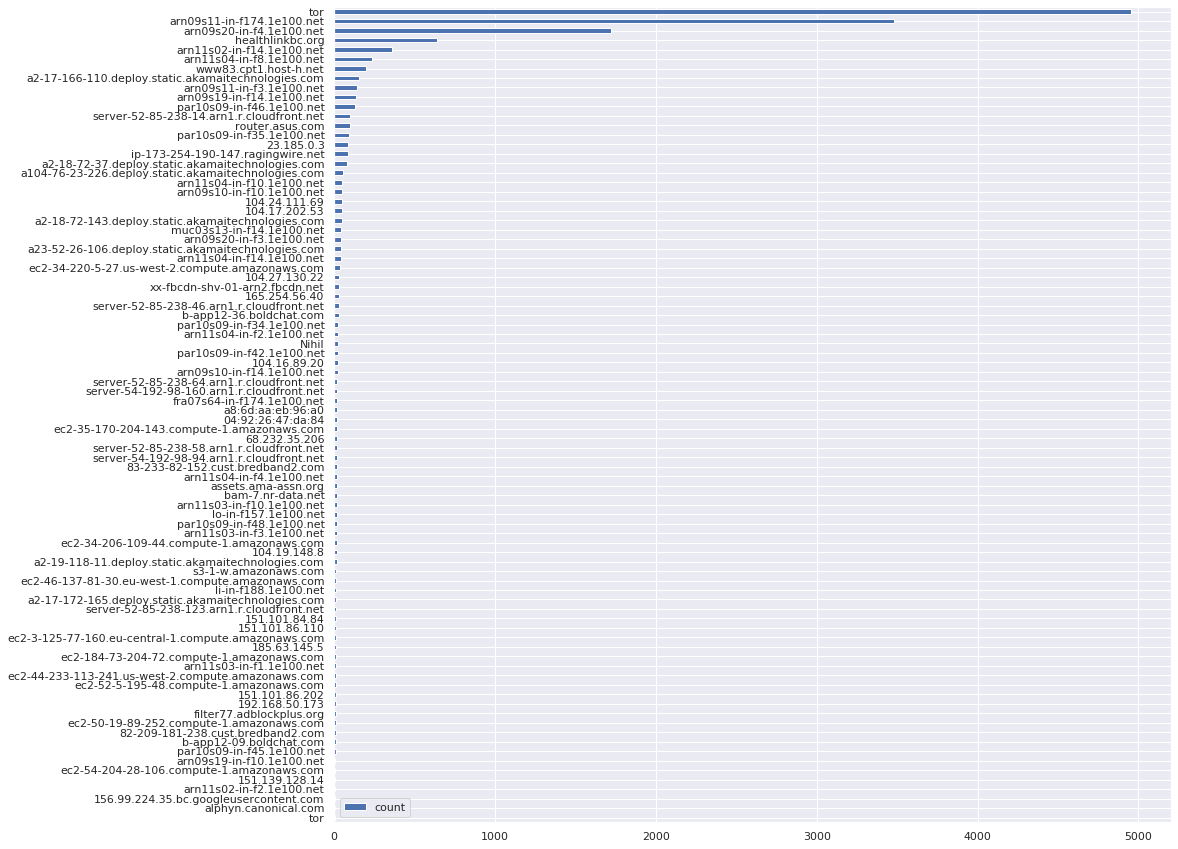

In [8]:
def get_all_interactions(packet_df):
    print("Extracting visited sites")
    
    x = df.groupby('src').count()[['version']]

    print("Attempting reverse lookup to get hostname instead of ip")
    resolved_hosts = []
    for ip in x.index:
        try:
            resolved_hosts.append(socket.gethostbyaddr(ip)[0])
        except:
            resolved_hosts.append(ip)

    print("Plotting")
    x.index = resolved_hosts
    x = x.rename(columns = {"version" : "count"})
    x = x.sort_values(by='count', ascending = True)

    fig, ax = plt.subplots(figsize = (15,15))
    x.plot.barh(ax = ax)
    plt.show()
get_all_interactions(df)

In [11]:
def get_unique_hosts_in_subset(startOfSubset):
    selection = df[df['src'].str.startswith(startOfSubset)]
    return selection['src'].unique()
hosts = get_unique_hosts_in_subset('192.')  


print(hosts)
host = hosts[0]
# In EH, only my traffic gets captuerd 

['192.168.50.71' '192.168.50.60' '192.168.50.173' '192.168.50.1']


Extracting visited sites
Attempting reverse lookup to get hostname instead of ip
Plotting


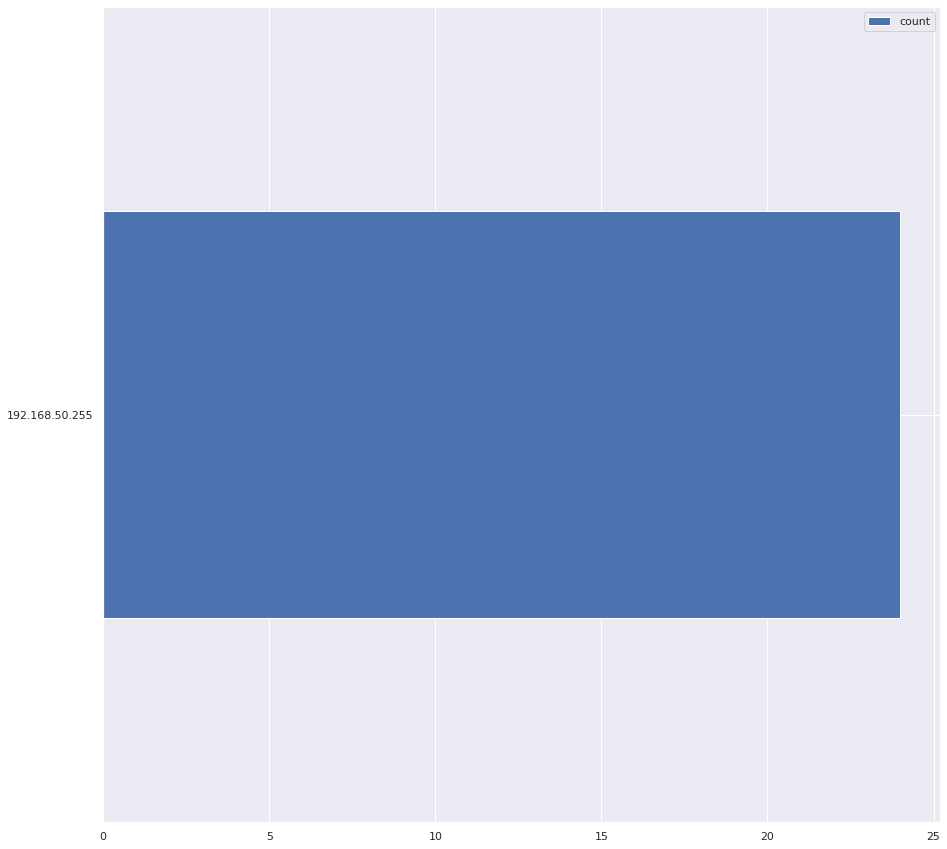

In [12]:
def get_sites_visited(packet_df, source_ip):
    print("Extracting visited sites")
    
    x = df[df['src'] == source_ip].groupby('dst').count()[['version']]

    print("Attempting reverse lookup to get hostname instead of ip")
    resolved_hosts = []
    for ip in x.index:
        try:
            resolved_hosts.append(socket.gethostbyaddr(ip)[0])
        except:
            resolved_hosts.append(ip)

    print("Plotting")
    x.index = resolved_hosts
    x = x.rename(columns = {"version" : "count"})
    x = x.sort_values(by='count', ascending = True)

    fig, ax = plt.subplots(figsize = (15,15))
    x.plot.barh(ax = ax)
    plt.show()
get_sites_visited(df, host)

192.168.50.71
Extracting visited sites
Attempting reverse lookup to get hostname instead of ip
Plotting


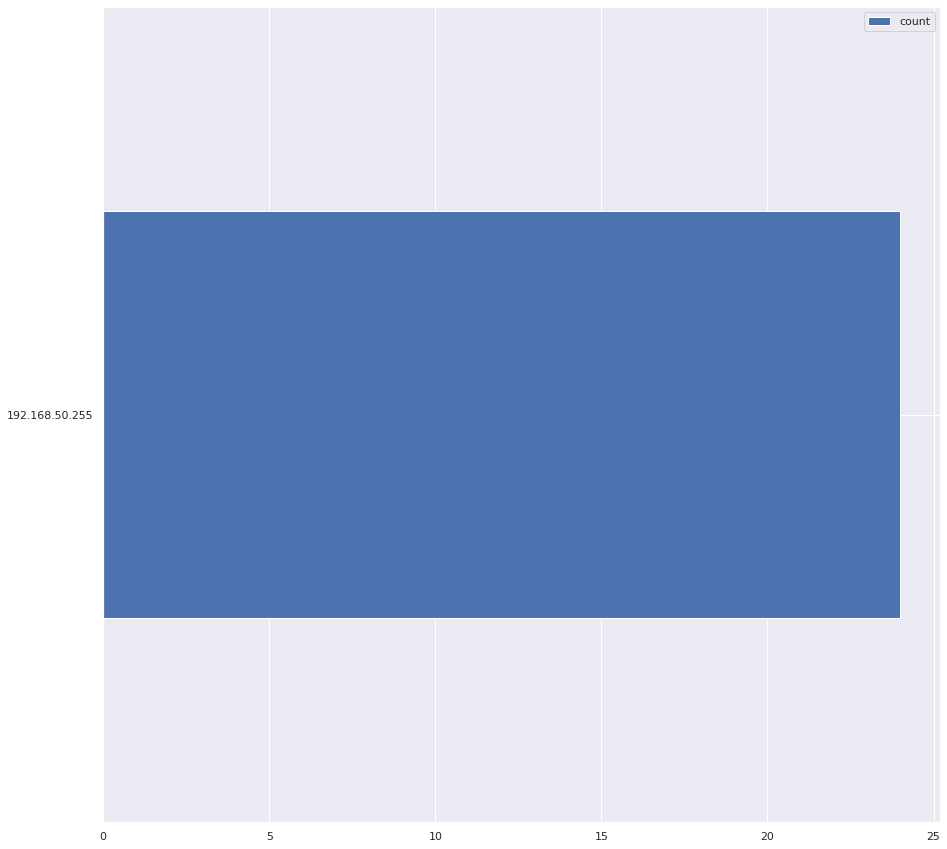

192.168.50.60
Extracting visited sites
Attempting reverse lookup to get hostname instead of ip
Plotting


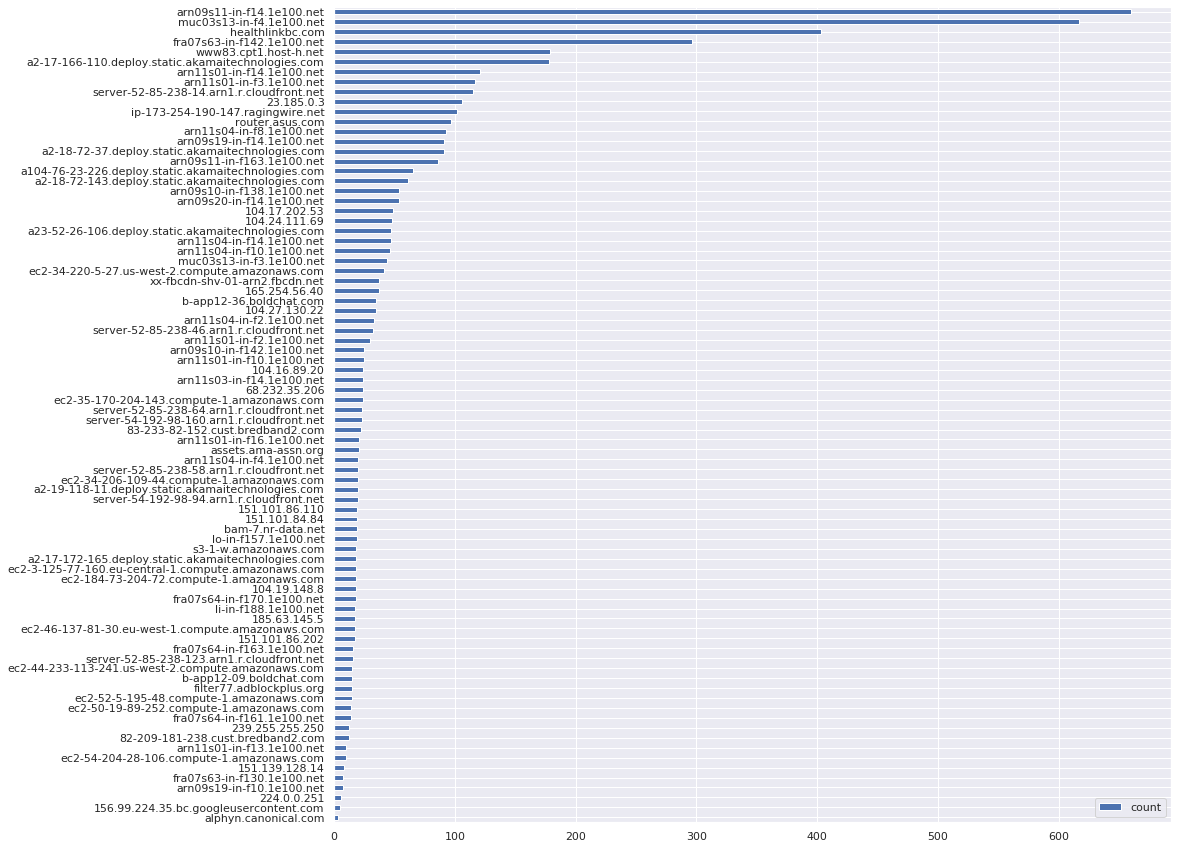

192.168.50.173
Extracting visited sites
Attempting reverse lookup to get hostname instead of ip
Plotting


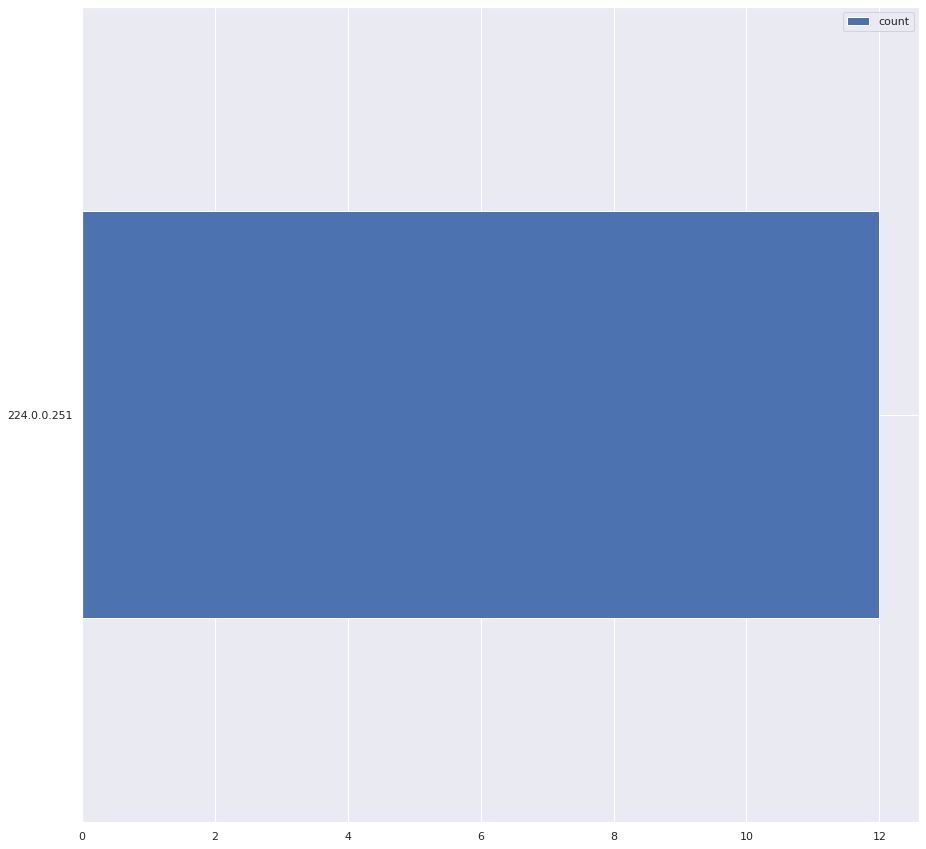

192.168.50.1
Extracting visited sites
Attempting reverse lookup to get hostname instead of ip
Plotting


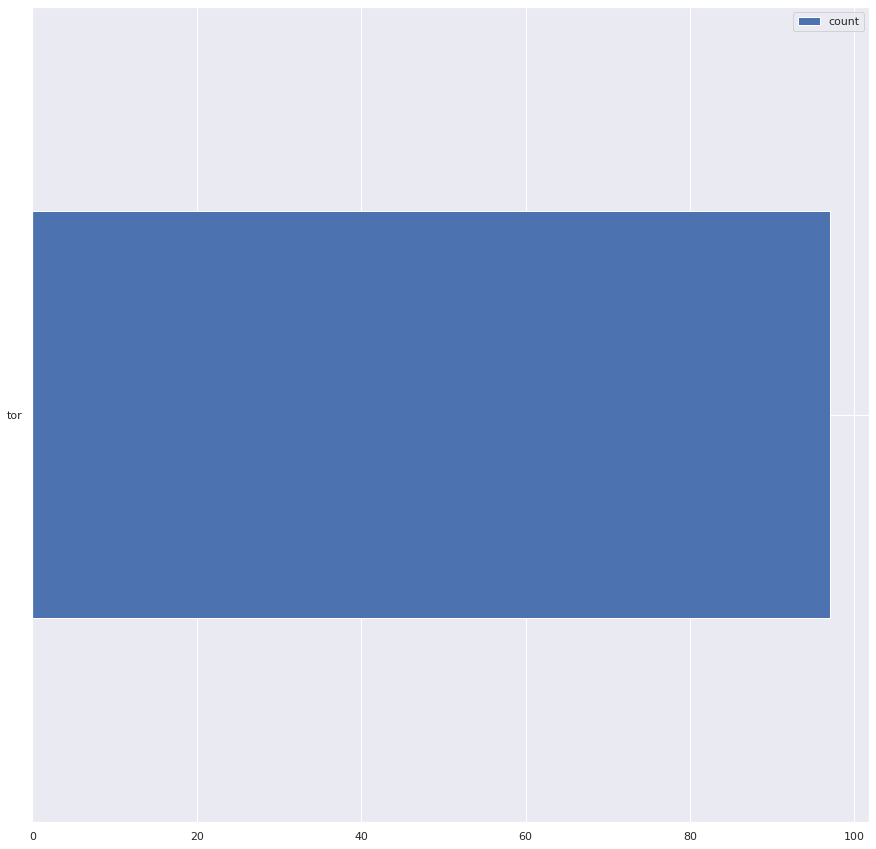

In [13]:
def show_sites_visited_per_host_in_subnet(subnet='192.168'):
    hosts = get_unique_hosts_in_subset(subnet) 
    for host in hosts:    
        print(host)
        get_sites_visited(df, host)
show_sites_visited_per_host_in_subnet()

In [ ]:
df['proto'].unique()

In [ ]:
test = df[df['proto'] == 'TCP']
test[test['sport'] == '80']

In [ ]:
def watch_all_dns_requests():
    print("DNS requests")
    
df[df['qd'] != '-'].head(1)

In [ ]:
scapy_structured_dns_response = df.l

In [ ]:
def get_DNS_answers(packets):
    for packet in packets:
        # We're only interested packets with a DNS Round Robin layer
        if packet.haslayer(DNSRR):
            # If the an(swer) is a DNSRR, print the name it replied with.
            if isinstance(packet.an, DNSRR):
                print(packet.an.rrname)


In [ ]:
def get_all_plaintext():
    print("Extracting all plaintext")

In [ ]:
def get_all_files():
    print("Extracting files")

In [ ]:
def get_all_p():
    print("Extracting info")

## Dataset notes
### EH
Cellphone visits wikipedia (lists of citrus fruits
Computer visits youtube, searches for inktale
### Nynas
Vic:
* Listen to calvin
* Send email containing "secret code 14534"
* Read mangakakalot
* Watch images on Nejimaki
* In incognito, enter tvtropes afro samurai
* Enter messenges
* Enter slack

Mar:
* Prolly wordfeud

Rob:
* Check superga shoes
* Search for acronym AIDS


In [ ]:
def show_sessions(packets):
    for s in packets.sessions():
        print(s)
        
def show_all(packets):
    for s in packets.sessions():
        for p in packets.sessions()[s]:
            try:
                if p[TCP].dport == 80 or p[TCP].sport == 80:
                    print(p[TCP].payload)
            except:
                pass

In [ ]:
get_DNS_answers(packets)

In [ ]:
# ETHERNET -> Internet Protocol -> Layer 4 Segments
# We're only interested in Layers 3 (IP) and 4 (TCP AND UDP) 
## We'll parse those two layers and the layer 4 payload
## When capturing we capture layer 2 frames and beyond

# Retrieving a single item from packet list
ethernet_frame = packets[0]
ip_packet = ethernet_frame.payload
segment = ip_packet.payload
data = segment.payload # Retrieve payload that comes after layer 4

# Observe that we just popped off previous layer header
print(ethernet_frame.summary())
print(ip_packet.summary())
print(segment.summary())
print(data.summary()) # If blank, empty object

# Complete depiction of paket
## Achieving understanding that these are the fields will enable the ability 
## to ask the data more meaningful questions ie) type of layer 4 segment is defined in layer 3 packet
ethernet_frame.show()

In [ ]:
ethernet_frame = packets[0]
ip_packet = ethernet_frame.payload
segment = ip_packet.payload
data = segment.payload # Retrieve payload that comes after layer 4


segment.show()

In [ ]:
# Understanding the object types in scapy
print(type(ethernet_frame))
print(type(ip_packet))
print(type(segment))

# Packets can be filtered on layers ie) ethernet_frame[scapy.layers.l2.Ether]
ethernet_type = type(ethernet_frame)
ip_type = type(ip_packet)
tcp_type = type(segment)
print("Ethernet",packets[ethernet_type])
print("IP", packets[ip_type])
print("TCP", packets[tcp_type])

# Scapy provides this via import statements
from scapy.layers.l2 import Ether
from scapy.layers.inet import IP
from scapy.layers.inet import TCP, UDP

print("UDP", packets[UDP])
